In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload

## Solving the Ising model with TEBD (time-evolving block decimation)
### (0) Derivation of the transfer matrix of the 1D classical Ising model

1D spin chain:

<img src="Ising_1D.png" alt="Caption" width="300"/>

source: Paolasini magnetism lecture 7

The Hamiltonian of the classical 1D Ising model with $N$ spins is given by  
$$H = -J \sum_{<i,j>} \sigma_i \sigma_j,$$
where $\sigma_i$ are classical spins that can take values $+1$ and $-1$, $J$ is the coupling constant between neighboring spins. 
The partition function of this system is 
$$Z = \text{Tr} ( e^{-\beta H}) = \sum_{\{ \sigma \} } \prod_{<i,j>} e^{J\beta \sigma_i \sigma_j},$$
with the inverse temperature $\beta= 1/k_BT$. The sum is over all possible microstates of the spin chain. 
We define the so-called transfer matrix in the space of two neighboring spins as
$$T =  \begin{pmatrix} e^{J\beta} & e^{-J\beta} \\ e^{-J\beta} & e^{J\beta} \end{pmatrix} ,$$
such that the partition function simply reduces to a matrix multiplication problem: 
$$Z = \text{Tr} ( T^N) .$$

### (1) Expressing the partition function of the 2D classical Ising model as a tensor network

Now we study the 2D Ising model on a square lattice:

<img src="Ising_2D.png" alt="Caption" width="300"/>

source: Paolasini magnetism lecture 7

Each spin has $4$ nearest neighbors: top, left, bottom, right. For a single bond we can recycle the transfer matrix $T$ from the 1D Ising model. It will be advantageous to factorize this matrix as follows
$$T_{\sigma_i,\sigma_j} = \sum_{\sigma_k} W_{\sigma_i, \sigma_k} W_{\sigma_j, \sigma_k},$$
with the matrix $W$ given by 
$$W =  \begin{pmatrix} \sqrt{\cosh J\beta} & \sqrt{\sinh J \beta } \\ \sqrt{\cosh J\beta} & -\sqrt{\sinh J \beta } \end{pmatrix}.$$
From this, a local tensor at each site $i$ can be constructed as
$$A_{u_i,d_i,l_i,r_i}^{i} = \sum_{\sigma_i} W_{\sigma_i, u_i}W_{\sigma_i, d_i}W_{\sigma_i, l_i}W_{\sigma_i, r_i}.$$
I think this is easiest understood from the following graphic: 

<img src="site_tensor.png" alt="Caption" width="500"/>

source: Zhao et. al., PRB 93, 125115 (2016)

#### (2) Using TEBD to contract the tensor network 

If we rotate the lattice by $45^°$, it becomes clear that we can use the TEBD algorithm to perform the contraction of the tensor network.

<img src="TEBD.png" alt="Caption" width="800"/>

source: Pollmann https://arxiv.org/pdf/1805.00055

In [12]:
import sys
sys.path.append('/Users/mina-lou/Desktop/Frank')
import isingtebd 
import importlib
import matplotlib.pyplot as plt 
import numpy as np 

In [45]:
# define some parameters 

J=1             # interaction strength
chi_m=60       # maximum virtual bond dimension 
eps=1e-12       # cutoff for singular values of 2-site wavefunction \Theta
Nx=40           # number of sites in x
N_steps = 20    # number of update steps / 2 in y 

betas = np.arange(0.1,1.0,0.05)
print(betas)


[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95]


In [48]:
# measure magnetisation for different values of beta 
mags = isingtebd.get_mag_curve(Nx,betas,J,N_steps,chi_m,eps)  

In [ ]:
#np.save("data/mag_curve_J=1_chi=60_eps=1e-12_Nx=80_steps=40_B", mags)
#np.save("data/betas_B", betas) 
#mags = np.load("/Users/mina-lou/Desktop/Frank/isingtebd/results/data/mag_curve_J=1_chi=100_eps=1e-20_Nx=20_steps=10_A.npy")
#betas = np.load("/Users/mina-lou/Desktop/Frank/isingtebd/results/data/betas_A.npy") 

### Magnetization vs. Temperature

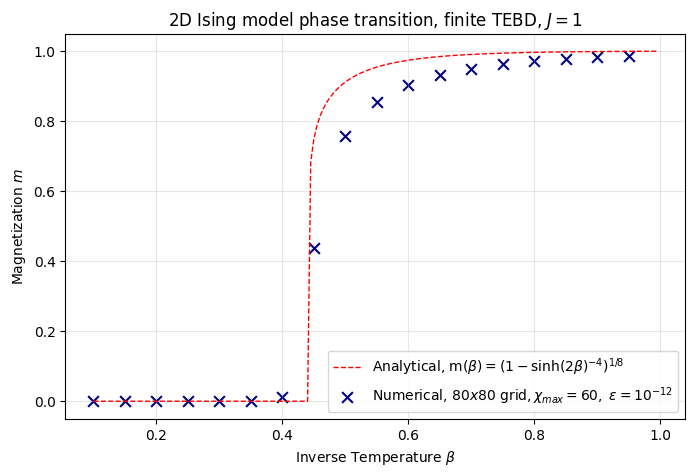

In [55]:
#plot results
beta_crit = 1/isingtebd.critical_temp_analytic(J)
betas_analytic = np.arange(0.1,1.0,0.005)
mags_analytic = []
for beta in betas_analytic:
    mags_analytic.append(isingtebd.mag_analytic(beta,J))
 
plt.figure(figsize=(8,5))

plt.plot(betas_analytic, mags_analytic, 'r--', linewidth=1, label=r'Analytical, m$(\beta)=(1-\sinh(2\beta)^{-4})^{1/8}$')
plt.scatter(betas, mags, color='navy', marker='x', s=60, label=r'Numerical, $80x80$ grid,$ \, \chi_{max}=60$, $\, \epsilon=10^{-12}$')

plt.xlabel(r'Inverse Temperature $\beta$')
plt.ylabel('Magnetization $m$')
plt.title(r'2D Ising model phase transition, finite TEBD, $J=1$')
plt.legend()
plt.grid(alpha=0.3)
plt.show() 
#plt.savefig("magnetization_vs_beta.png", dpi=300, bbox_inches='tight') 

The analytical result for the critical temperature $T_c$ of the 2D Ising model is the following 
$$k_B T_c = \frac{2J}{\ln (1+\sqrt{2})} \approx 2.269 J.$$
The corresponding inverse critical temperature $\beta_c$ is 
$$\beta_c = \frac{1}{k_B T_c} \approx 0.441 / J,$$
which perfectly matches the numerical result above for $J=1$ 

#### (3) using iTEBD, periodic boundary conditions

In [29]:
J=1             # interaction strength
chi_m=60        # maximum virtual bond dimension 
eps=1e-12       # cutoff for singular values of 2-site wavefunction \Theta, keep around 1e-10
Nx=40           # number of sites in x
N_steps = 20    # number of update steps / 2 in y 

betas2 = np.arange(0.1,1.0,0.05) 
extra = [0.41,0.42,0.43,0.44,0.46]
betas2 = np.concatenate((betas2,extra)) 
mags_inf = isingtebd.get_mag_curve(Nx,betas2,J,N_steps,chi_m,eps,"infinite") 

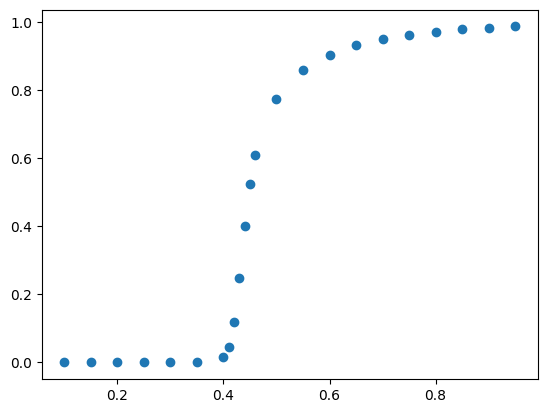

In [30]:
plt.scatter(betas2, mags_inf)  

### Correlation length vs. temperature

The correlation length can be calculated from the highest and second highest eigenvalue of the local transfer matrix ($\epsilon_1$ and $\epsilon_2$ respectively). It's dimensions are $\chi^2 \times \chi^2$. More explicitly, the correlation length $\xi$ is defined as
$$\xi = - \frac{1}{\ln |\frac{\epsilon_2}{\epsilon_1}|}.$$

In [31]:
corrs = isingtebd.get_correlation_curve(Nx,betas2,J,N_steps,chi_m,eps) 

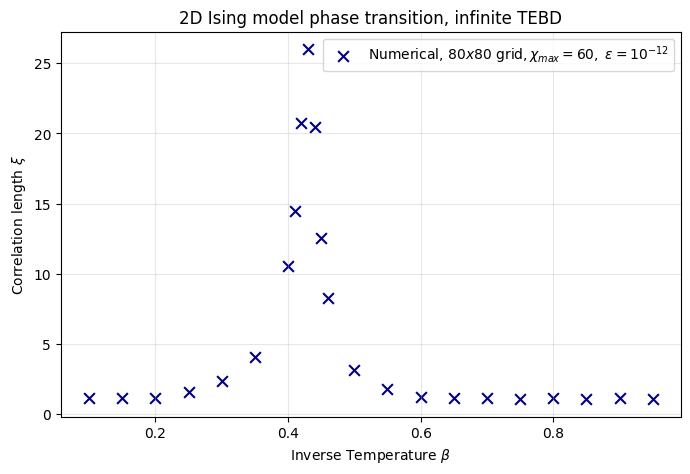

In [49]:
plt.figure(figsize=(8,5))
plt.scatter(betas2,corrs, color='navy', marker='x', s=60, label=r'Numerical, $80x80$ grid,$ \, \chi_{max}=60$, $\, \epsilon=10^{-12}$' )
plt.xlabel(r'Inverse Temperature $\beta$')
plt.ylabel(r'Correlation length $\xi$')
plt.title('2D Ising model phase transition, infinite TEBD')
plt.legend()
plt.grid(alpha=0.3)
plt.show() 
#plt.savefig("correlation_vs_beta.png", dpi=300, bbox_inches='tight') 